# Classification project - classify category by nutrition valus

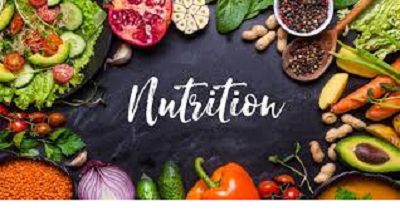

### In this project, we want to check the possibility of categorizing products by their nutritional values

- We started by doing web-scraping from the website of the grocery network 'Shufersal'. https://www.shufersal.co.il/online/he/A
- Then, we did an initial cleanup of the dataset, we assumed that In the future cases the test's dataset might arrive "dirty", so that all the operations during the wide cleanup can be applied with function that is functioning as a pipeline, also to the test dataset we get without being dependent on our cleaned dataset.

### Table of Contents:
    1. Getting to know the data, initial data cleanse, train test split.
    2. Analyzing and visualizing the data
    3. Merging columns that present same or very similar items
    4. Building a function that is functioning as a pipeline
    5. dummy-model
    6. Sampling models (and checking with cross validation):
        a. knn classifier + grid search
        b. random forest classifier
    5. comparing models scores and choosing the final model
    6. conclusion

In [78]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error as MSE

plt.style.use('seaborn')

In [79]:
df = pd.read_csv ('dataclassification_converted_to_english.csv', index_col = False)

In [80]:
df.head()

,product_name,code,category_name,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,...,K_Potassium,humidity,chromium,Molybdenum,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,P_964560,fruits,0.09,0.08,1.7,24.0,47.0,9.0,12.0,...,0,0,0,0,0,0,0,0,0,0.0
1,Gilded_apple,P_963136,fruits,0.00,0.00,2.4,0.0,52.0,0.3,13.8,...,0,0,0,0,0,0,0,0,0,0.0
2,lemon,P_964492,fruits,0.00,0.08,2.8,0.0,29.0,1.1,9.3,...,0,0,0,0,0,0,0,0,0,0.0
3,Orange_in_the_juice_network,P_964348,fruits,0.09,0.06,2.5,39.0,49.0,1.0,11.9,...,0,0,0,0,0,0,0,0,0,0.0
4,Avocado,P_964980,fruits,0.07,0.30,6.7,81.0,160.0,2.0,8.5,...,0,0,0,0,0,0,0,0,0,0.0


## Splitting the Data

In [81]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)
prod = train_set.copy()

In [84]:
prod.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
#set code as index for removing duplicate values, might be different products with the same name, but not with same code 
prod = prod.set_index(['code']) 
prod = prod.drop_duplicates()
prod = prod.set_index(['product_name'])
prod

,category_name,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,...,K_Potassium,humidity,chromium,Molybdenum,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
product_name,,,,,,,,,,,,,,,,,,,,,
Moroccan_cookies_for_school,Pastries_and_cakes_from_the_bakery,0.0,0.0,0.0,0.0,485.0,7.7,67.2,24.4,290.0,...,0,0,0,0,0,0,0,0,0,0.0
Chickpea_Chips_Chips_L._Gluten_Free,Gluten_free,0.0,0.0,3.5,0.0,465.0,7.9,68.0,18,0.0,...,0,0,0,0,0,0,0,0,0,0.0
Yopla_on_top_crackles,Milk_and_eggs,0.0,0.0,0.0,0.0,108.0,4.5,12.8,4.3,58.0,...,0,0,0,0,0,0,0,0,0,0.0
Chocolate_spread_for_GHS,Diet_and_sugar_free,0.0,0.0,0.0,464.0,5.0,51.0,34.0,28,0.0,...,0,0,0,0,0,0,0,0,0,NaN
Chocolate_Mercy_Nut_Hazelnut_+_Almond,snacks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A_quarter_to_seven_salted_caramel_mousse,snacks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
Candy_Goldvers,snacks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0.0
Market.Milka_Oreo_Sandwich,snacks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0.0


In [85]:
products = prod.drop("category_name", axis=1)
category_not_encoded = prod["category_name"].copy()
products.shape, category_not_encoded.shape

((7454, 97), (7454,))

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9581 entries, 0 to 9580
Data columns (total 100 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   product_name                         9581 non-null   object 
 1   code                                 9581 non-null   object 
 2   category_name                        9581 non-null   object 
 3   Vitamin_B1                           9581 non-null   float64
 4   Vitamin_B6                           9581 non-null   float64
 5   Dietary_fiber                        9581 non-null   float64
 6   Folic_acid                           9581 non-null   float64
 7   energy                               9580 non-null   float64
 8   Proteins                             9580 non-null   float64
 9   Carbohydrates                        9566 non-null   float64
 10  Fats                                 9581 non-null   object 
 11  sodium                       

## wide cleanup

**convert all of the cells to numeric display, fill the empty cells, and drop all the columns containing only zeros**

In [87]:
for col in products.columns:  
    products[col] = pd.to_numeric(products[col], errors='coerce')
products = products.fillna(0)
sts_dropped_collumns = np.transpose(products.loc[:, (products == 0).all(axis=0)]).index
products = products.loc[:, (products != 0).any(axis=0)]

**In order to reduce background noise, we decided to remove the columns that are relevant to less than 20 products with this feature**

In [88]:
products = products.reset_index()
arr = np.array([])
col_droped = np.array([])
for col in products.columns:
    if products[col].astype(bool).sum(axis=0)<20: 
        arr = np.append(arr, products[col].to_numpy().nonzero())
        col_droped = np.append(col_droped, col)
print("the columns that are relevant to less than 20 products is:\n\n",col_droped)

arr = set(arr) #all number of rows without duplicates
for i in arr:
    products = products.drop(i) #deletes all rows which contains one of these low importance nutrition values
products = products.drop(col_droped, axis=1) #deletes all columns with all values set to zero
products = products.set_index(['product_name'])
products.shape

the columns that are relevant to less than 20 products is:

 ['Polyunsaturated_fat' 'Proteins_(Albumin_|_Casein_40_|_60)'
 'From_the_carbohydrates_lactose' 'Vitamin_D_Calciprolol'
 '3_omega_fatty_acids' 'Niacin' 'Vitamin_B5' 'Pantothenic_acid'
 'Saturated_fat' 'Trans_fat' 'Nicotinamide' 'Non-fibrous_fibers'
 'Of_which_unsaturated_fat' '6_omega_fatty_acids' 'Salt' 'manganese'
 'Soluble_fiber' 'Acetic_acid' 'Ascorbic_acid' 'Inositol' 'Carnitine'
 'Chloride' 'AA_fatty_acid' 'Vitamin_B3_Nicotinamide_Equilibrium'
 'K_Potassium' 'Molybdenum' 'Unsaturated' 'Acidic_acid' 'Linoleic_acid'
 'DHA' 'EPA']


(7300, 57)

In [89]:
category_not_encoded = category_not_encoded.reset_index()
for i in arr:
    category_not_encoded = category_not_encoded.drop(i)
category_not_encoded = category_not_encoded.set_index(['product_name'])
category_not_encoded.head()

,category_name
product_name,
Moroccan_cookies_for_school,Pastries_and_cakes_from_the_bakery
Chickpea_Chips_Chips_L._Gluten_Free,Gluten_free
Yopla_on_top_crackles,Milk_and_eggs
Chocolate_spread_for_GHS,Diet_and_sugar_free
Chocolate_Mercy_Nut_Hazelnut_+_Almond,snacks


.

### display the amount of products for every category

In [90]:
print (category_not_encoded.value_counts())

category_name                     
Baking_and_canning_cooking            1504
snacks                                1388
Milk_and_eggs                         1021
Refrigerated_food                      892
Cooking_and_baking_products            275
For_those_who_avoid_gluten             256
Cooking                                227
Health_in_the_refrigerator             187
From_the_freezer                       181
bread                                  178
Refrigerator_products_and_eggs         178
Gluten_free                            162
Vitamins_and_supplements               130
Cereals                                118
Diet_and_sugar_free                    101
Pastries_and_cakes_from_the_bakery      85
vegetables                              77
For_baby_-_food                         76
Without_added_sugar                     63
Nuts_and_dried_fruits                   60
Babies_and_children                     48
Breads                                  31
Organic_fruits_and_

## Analyzing our data

### from looking at the categories, we infered that we can unite categories:

- **Baking and Cooking**
    - Baking_and_canning_cooking
    - Cooking_and_baking_products
    - Cooking
- **Refrigerated_food**
    - Milk_and_eggs
    - Refrigerated_food
    - Refrigerator_products_and_eggs
    - Health_in_the_refrigerator
- **Gluten_free**
    - For_those_who_avoid_gluten
    - Gluten_free
- **Diet_and_sugar_free**
    - Without_added_sugar
    - Diet_and_sugar_free
- **Fruits and Vegtables**
    - Organic_fruits_and_vegetables
    - fruits
    - vegetables
    - Nuts_and_dried_fruits
- **meat, chicken and fish products**
    - Chicken_and_turkey_products
    - Fish
    - Beef_and_lamb
- **Bread and Bakery**
    - Breads
    - bread
    - Pastries_and_cakes_from_the_bakery
- **Babies_and_children**
    - For_baby_-_food
    - Babies_and_children
    
- **columns can be removed**
    - House_cleaning_and_one-time - it's probably a mistake done while scraping
    - Clearance_of_inventory - there are other factors that affect product's presence in this category

In [91]:
Dict = {'Baking_and_canning_cooking':'Baking and Cooking',
                                                     'Cooking_and_baking_products':'Baking and Cooking',
                                                    'Cooking':'Baking and Cooking',
                                                    'Milk_and_eggs':'Refrigerated_food',
                                                    'Refrigerator_products_and_eggs':'Refrigerated_food',
                                                    'Health_in_the_refrigerator':'Refrigerated_food',
                                                    'For_those_who_avoid_gluten':'Gluten_free',
                                                    'Without_added_sugar':'Diet_and_sugar_free',
                                                    'Organic_fruits_and_vegetables':'Fruits and Vegtables',
                                                    'fruits':'Fruits and Vegtables','vegetables':'Fruits and Vegtables',
                                                    'Nuts_and_dried_fruits':'Fruits and Vegtables',
                                                    'Chicken_and_turkey_products':'Meat, chicken and fish products',
                                                    'Fish':'Meat, chicken and fish products',
                                                     'Beef_and_lamb':'Meat, chicken and fish products',
                                                    'Breads':'Bread and Bakery', 'bread':'Bread and Bakery',
                                                     'Pastries_and_cakes_from_the_bakery':'Bread and Bakery',
                                                    'For_baby_-_food':'Babies_and_children'}
category_not_encoded = category_not_encoded.replace(Dict)

In [92]:
rows_to_drop = np.array([])
row = 0
for cat in category_not_encoded['category_name']:
    if (cat=='Clearance_of_inventory') or (cat=='House_cleaning_and_one-time'):
        rows_to_drop = np.append(rows_to_drop, row)
    row=row+1
category_not_encoded = category_not_encoded.reset_index()    
category_not_encoded = category_not_encoded.drop(rows_to_drop, axis=0)
category_not_encoded = category_not_encoded.set_index('product_name', drop=True)       
rows_to_drop

array([ 617.,  741.,  774., 1108., 1322., 1456., 2484., 2756., 3158.,
       4067., 4315., 4912., 5591., 5840., 6465., 6921.])

In [96]:
ordinal_encoder = OrdinalEncoder()
category_encoded1 = ordinal_encoder.fit_transform(category_not_encoded)
categories = ordinal_encoder.categories_
enc = OneHotEncoder()
categoryarr = enc.fit_transform(category_not_encoded)
categoryarr1 = categoryarr.toarray()
category = pd.DataFrame(categoryarr1, columns = categories[0], index=category_not_encoded.index)

## merging columns that are present the same or very similar nutrition values

In [94]:
def merge_two_columns(col1, col2, dataframe, index_col):
    if col1 in dataframe.columns and col2 in dataframe.columns:  #if both the columns exists
        dataframe = dataframe.reset_index()
        row = 0
        for prod in dataframe[col1]:
            if (prod==0):
                if (dataframe.at[row , col2]!=0):
                    dataframe.at[row, col1] =  dataframe.at[row ,col2]  
            row = row+1
        dataframe = dataframe.drop([col2], axis = 1)
        dataframe = dataframe.set_index(index_col, drop=True)
        return dataframe
    else:
        return dataframe

In [95]:
products = products.reset_index() 
products = products.drop(rows_to_drop, axis=0)
products = products.set_index('product_name', drop=True) 

#all these transformations are explained in the regression project that's attached below
products = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', products, 'product_name')
products = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', products, 'product_name')
products = merge_two_columns('potassium', 'K_Potassium', products, 'product_name')
products = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', products, 'product_name')
products = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', products, 'product_name')
products = merge_two_columns('Vitamin_B3', 'Niacin', products, 'product_name')
products = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', products, 'product_name')
products = merge_two_columns('Vitamin_B3', 'Nicotinamide', products, 'product_name')
products = merge_two_columns('sodium', 'chloride', products, 'product_name')

products['Partof_vitaminB'] = products['Vitamin_B6']
products = products.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B12','Folic_acid','Vitamin_B3'], axis=1)

products = products.drop(['Carbohydrate_sugars'], axis=1)

products = products.drop(['energy'], axis=1)

products['6_omega_fatty_acids'] = products['ARA_fatty_acid']
products = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', products, 'product_name')
products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid.1', products, 'product_name')
products = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', products, 'product_name')
products['3_omega_fatty_acids'] = products['DHA_fatty_acid']
products = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', products, 'product_name')
products = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', products, 'product_name')

products['have_to_do_with_babyfood'] = products['Lutein'] 
products = merge_two_columns('have_to_do_with_babyfood', 'Lutein', products, 'product_name')
products = merge_two_columns('have_to_do_with_babyfood', 'Choline', products, 'product_name')
products = merge_two_columns('have_to_do_with_babyfood', 'Taurine', products, 'product_name')

## analyze the data by correlation comparing

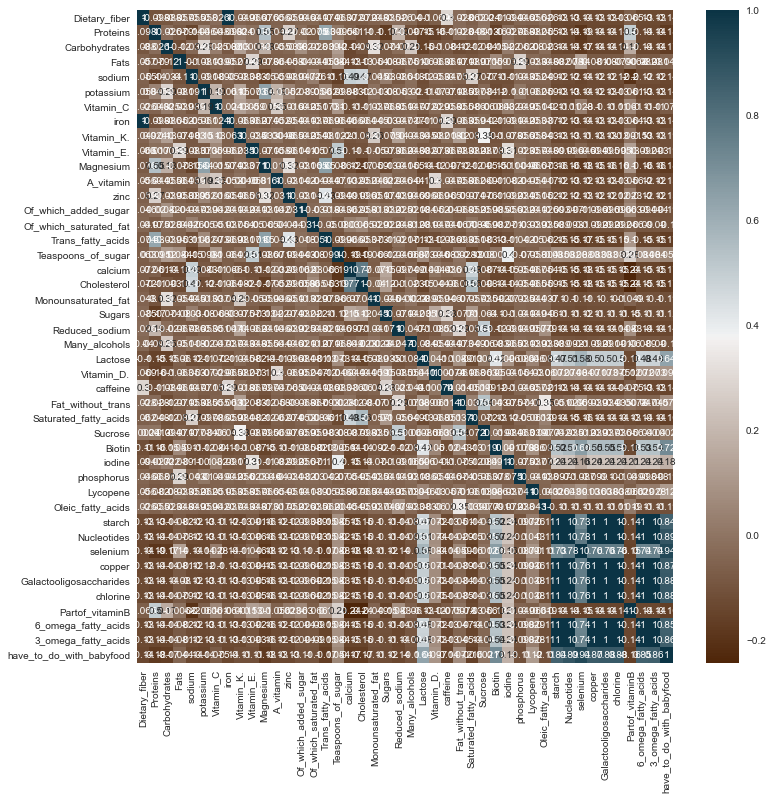

In [97]:
corr = products.corr()
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

### focus on the high-correlation corner square 

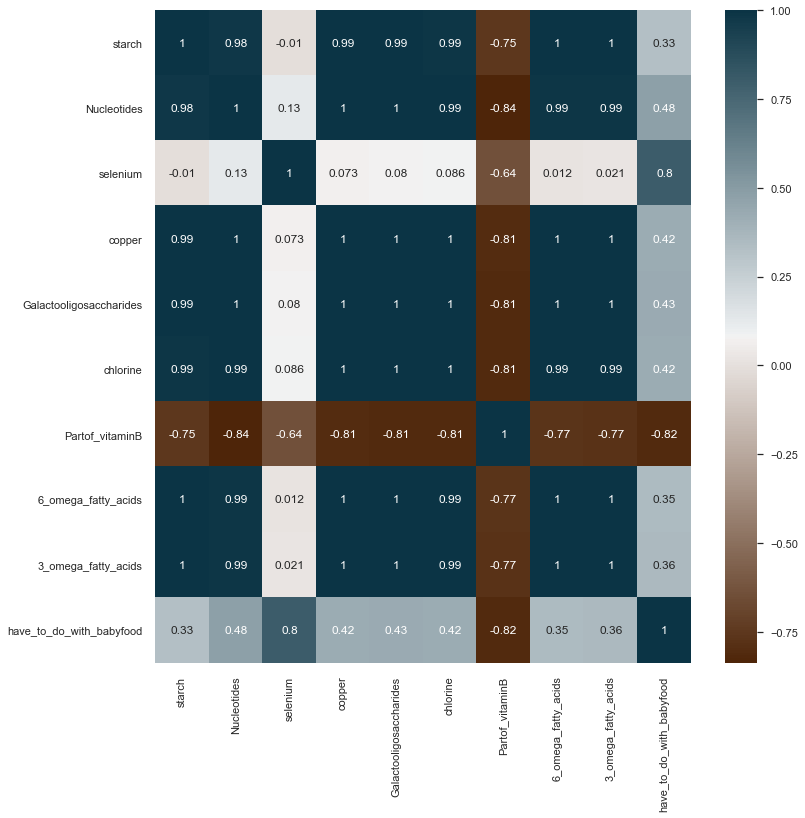

In [98]:
corr = products.loc[:,'starch':].corr()
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

## Due to the high correlations, we decided to merge all those that have a correlation of almost 1 under the column Omega Fatty Acids

In [99]:
products['omega_fatty_acids'] = products['3_omega_fatty_acids']
products = merge_two_columns('omega_fatty_acids', '3_omega_fatty_acids', products, 'product_name')
products = merge_two_columns('omega_fatty_acids', '6_omega_fatty_acids', products, 'product_name')
products = merge_two_columns('omega_fatty_acids', 'chlorine', products, 'product_name')
products = merge_two_columns('omega_fatty_acids', 'Galactooligosaccharides', products, 'product_name')
products = merge_two_columns('omega_fatty_acids', 'copper', products, 'product_name')
products = merge_two_columns('omega_fatty_acids', 'Nucleotides', products, 'product_name')
products = merge_two_columns('omega_fatty_acids', 'starch', products, 'product_name')

# End of data clening
### We will create a new function that contains all the cleaning operations we have performed so far so that when new information is received for test - the function will clear it according to the training


In [53]:
def get_data_ready(data):
    dataw1 = data.copy()
    dataw1.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
    dataw1 = dataw1.set_index(['code']) 
    dataw1 = dataw1.drop_duplicates()
    dataw1 = dataw1.set_index(['product_name'])
    
    dataw = dataw1.drop("category_name", axis=1)
    category_not_encodedw = dataw1["category_name"].copy()
    
    columns_need_to_drop = np.array([])
    columns_need_to_drop = np.append(columns_need_to_drop, sts_dropped_collumns)
    columns_need_to_drop = np.append(columns_need_to_drop, col_droped)
    columns_need_to_drop = set(columns_need_to_drop)
    
    dataw = dataw.drop(columns_need_to_drop, axis=1)
        
    for col in dataw.columns:  
        dataw[col] = pd.to_numeric(dataw[col], errors='coerce')
    dataw = dataw.fillna(0)
    
    category_not_encodedw = category_not_encodedw.replace(Dict)
    
    rows_to_dropw = np.array([])
    row = 0
    for cat in category_not_encodedw:
        if (cat=='Clearance_of_inventory') or (cat=='House_cleaning_and_one-time'):
            rows_to_dropw = np.append(rows_to_dropw, row)
        row=row+1    
    category_not_encodedw = category_not_encodedw.reset_index()
    category_not_encodedw = category_not_encodedw.drop(int(rows_to_dropw), axis=0)
    category_not_encodedw = category_not_encodedw.set_index(['product_name'], drop=True)
    
    category_encoded1w = ordinal_encoder.transform(category_not_encodedw)
    categoriesw = ordinal_encoder.categories_
    categoryarrw = enc.transform(category_not_encodedw)
    categoryarr1w = categoryarrw.toarray()
    categoryw = pd.DataFrame(categoryarr1w, columns = categoriesw[0], index=category_not_encodedw.index)
    
    dataw = dataw.reset_index()
    dataw = dataw.drop(rows_to_dropw, axis=0)
    dataw = dataw.set_index('product_name', drop=True)
    
    dataw = merge_two_columns('A_vitamin', 'Vitamin_A_is_worth_retinol', dataw, 'product_name')
    dataw = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dataw, 'product_name')
    dataw = merge_two_columns('potassium', 'K_Potassium', dataw, 'product_name')
    dataw = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dataw, 'product_name')
    dataw = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dataw, 'product_name')
    dataw = merge_two_columns('Vitamin_B3', 'Niacin', dataw, 'product_name')
    dataw = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dataw, 'product_name')
    dataw = merge_two_columns('Vitamin_B3', 'Nicotinamide', dataw, 'product_name')
    dataw = merge_two_columns('sodium', 'chloride', dataw, 'product_name')
    dataw['Partof_vitaminB'] = dataw['Vitamin_B6']
    dataw = dataw.drop(['Vitamin_B6','Vitamin_B1','Vitamin_B2','Vitamin_B12','Folic_acid','Vitamin_B3'], axis=1)
    dataw = dataw.drop(['Carbohydrate_sugars'], axis=1)
    dataw = dataw.drop(['energy'], axis=1)
    dataw['6_omega_fatty_acids'] = dataw['ARA_fatty_acid']
    dataw = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dataw, 'product_name')
    dataw = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid.1', dataw, 'product_name')
    dataw = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dataw, 'product_name')
    dataw['3_omega_fatty_acids'] = dataw['DHA_fatty_acid']
    dataw = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dataw, 'product_name')
    dataw = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dataw, 'product_name')
    
    dataw['omega_fatty_acids'] = dataw['3_omega_fatty_acids']
    dataw = merge_two_columns('omega_fatty_acids', '3_omega_fatty_acids', dataw, 'product_name')
    dataw = merge_two_columns('omega_fatty_acids', '6_omega_fatty_acids', dataw, 'product_name')
    dataw = merge_two_columns('omega_fatty_acids', 'chlorine', dataw, 'product_name')
    dataw = merge_two_columns('omega_fatty_acids', 'Galactooligosaccharides', dataw, 'product_name')
    dataw = merge_two_columns('omega_fatty_acids', 'copper', dataw, 'product_name')
    dataw = merge_two_columns('omega_fatty_acids', 'Nucleotides', dataw, 'product_name')
    dataw = merge_two_columns('omega_fatty_acids', 'starch', dataw, 'product_name')
    dataw['have_to_do_with_milk'] = dataw['Lutein'] 
    dataw = merge_two_columns('have_to_do_with_milk', 'Lutein', dataw, 'product_name')
    dataw = merge_two_columns('have_to_do_with_milk', 'Choline', dataw, 'product_name')
    dataw = merge_two_columns('have_to_do_with_milk', 'Taurine', dataw, 'product_name')
    
    return dataw, categoryw, category_not_encodedw

## Applying the test-dataset on the cleaning function we just built

In [54]:
test_products, test_categories, test_categories_encoded = get_data_ready(test_set)

## Dummy models

In [55]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(products, category)
y_predict = dummy_clf.predict_proba(test_products)
dummy_score = dummy_clf.score(test_products, test_categories)
print(dummy_score)

0.0


In [56]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(products, category)
dummy_score = dummy_clf.score(test_products, test_categories)
print(dummy_score)

0.08328940432261465


# models
## a. Knn

Knn is a model that searches by given parameters the closest n neighbors of an item

Text(0, 0.5, 'Testing Accuracy')

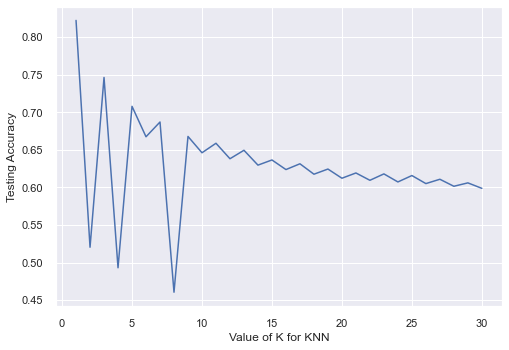

In [43]:
k_range = list(range(1, 31))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(products, category)
    cat_pred = knn.predict(products)
    scores.append(metrics.accuracy_score(category, cat_pred))
    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [44]:
max_score = max(scores)
best_K = scores.index(max(scores))+1

print("the first k value with best score is " + str(best_K) + " with accuracy of " + str(max_score))

the first k value with best score is 1 with accuracy of 0.8222130697419


Obviously, we won't choose k=1 because that's over fitting.

In [45]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

k_range = list(range(1, 31))
k_mean_scores = []
k_std_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, products, category, cv=kf, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())

d = {'k_mean': k_mean_scores, 'k_std': k_std_scores}
Ks = pd.DataFrame(data = d, index=k_range)

In [46]:
Ks['k_mean'].sort_values(ascending=False).head(10)

1     0.688347
3     0.681215
5     0.646337
7     0.630550
11    0.626848
9     0.623409
13    0.606386
17    0.595264
6     0.586880
27    0.580713
Name: k_mean, dtype: float64

In [47]:
Ks['k_std'].sort_values(ascending=True).head(10)

3     0.021901
11    0.028567
27    0.060467
1     0.060790
17    0.060811
28    0.060977
30    0.061002
9     0.061646
29    0.062055
13    0.062113
Name: k_std, dtype: float64

### We can see that k=3 has the best mean score (1 doesn't count), and in addition has the best (smallest) std. 
### Moreover, 3 is an odd number and therefor it's great for our needs.

### feature selection according the knn

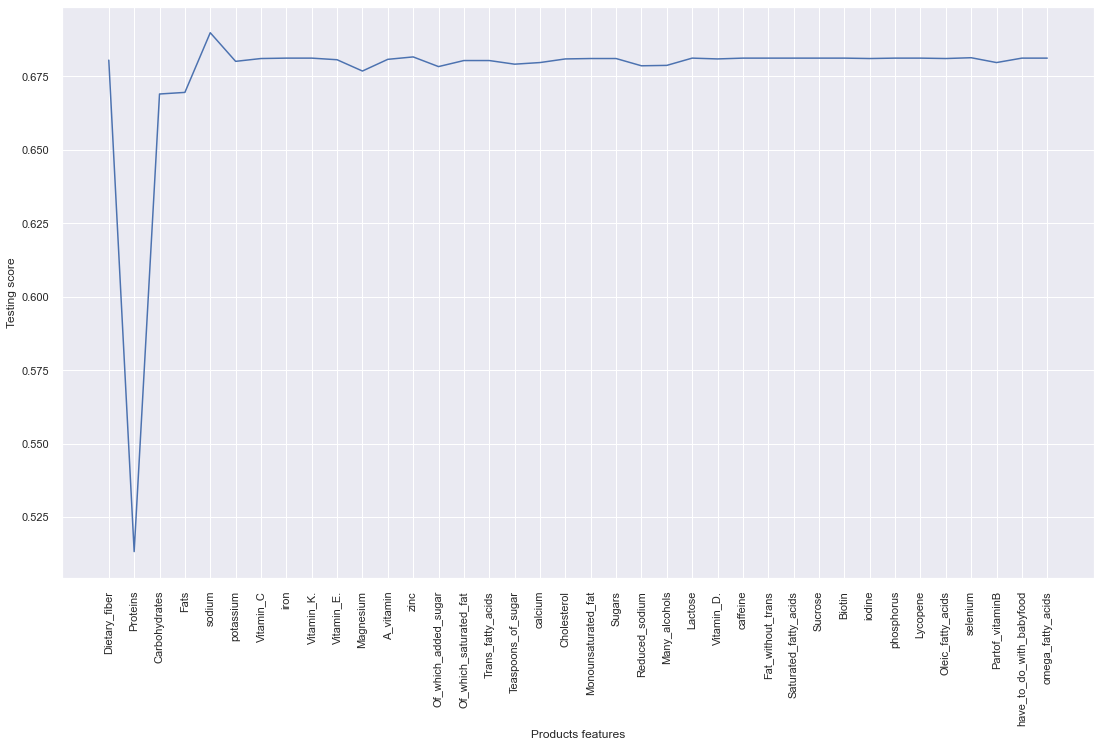

In [48]:
k_range = list(range(1, 31))
k_mean_scores = []
k_std_scores = []

features = list(products.columns.values)
for feature in features:
    knn = KNeighborsClassifier(n_neighbors= 3)
    scores = cross_val_score(knn, products.drop(columns=feature), category, cv=kf, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())
# check if there is an feature worthe to remove
fig = plt.gcf()
plt.plot(features, k_mean_scores)
plt.xlabel('Products features')
plt.ylabel('Testing score')
plt.xticks(rotation='vertical')

fig.set_size_inches(18.5, 10.5)

### By the accuracy of each feature in the graph above, we decided to not drop any of the columns above

## Knn with GridSearch

In [49]:
knn=KNeighborsClassifier()
k_range = list(range(2,31))
weight_options = ['uniform', 'distance']
metrics_options = ['euclidean', 'manhattan']
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metrics_options)
grid=GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy')
grid.fit(products, category)
print(grid.best_score_)
print(grid.best_params_)

0.7084007898822713
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [50]:
our_best_knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance')

## b. Random Forest Classifier

Random forest regressor is a model that creates a couple of binary trees, trying with the data set that has been given a random few of them and chooses the one that performed best.

In [51]:
random_for = RandomForestClassifier()
randomfor_score = cross_val_score(random_for, products, category, cv=kf, scoring='accuracy').mean()
print(randomfor_score)

0.7151319359652692


### we can see that the RandomForest model score (0.71) is better than the KNN model score (0.7) so we will choose the RandomForest model.

# Apllying the  testing on the model

In [57]:
random_for = RandomForestClassifier()
random_for.fit(products, category)
final_predict = random_for.predict(test_products)
print('Final accuracy score of model is: ', accuracy_score(test_categories,final_predict))

Final accuracy score of model is:  0.7127042698998418


# Conclusions
- as we can see the outcome score of the model is 71%
- we can infer that indeed there is connection and ability to classify products by their nutrition values
- we learned a lot during the project and assume this skills might help us in a lot of projects in the future

- We did a Regression Project with the same Dataset on the connection between nutrition values and price of a product:
https://github.com/shira-chesler/Data_Science_intro_project/blob/eedb95c3faaf6454ca5552c30aca790807fb99d0/Regression/regression_project.ipynb